# Category-Level Data Preparation

Extract and prepare ONS retail category-level internet sales proportion data from `internetreferencetables.xlsx`.

**Categories**:
- All retailing (excluding automotive fuel)
- Predominantly food stores
- Total predominantly non-food stores
- Non-specialised stores
- Textile, clothing & footwear stores
- Household goods stores
- Other stores
- Non-store retailing

## 0. Setup

In [25]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [26]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [27]:
# Data folders
raw_data_dir = Path.cwd().parent / "data" / "raw"
processed_data_dir = Path.cwd().parent / "data" / "processed"
processed_data_dir.mkdir(parents=True, exist_ok=True)

In [28]:
# Spans for time series charts
def add_event_spans(ax):
    return {
        'covid1': ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
                             color="#4BADFEBF", alpha=0.2, hatch='/', label='1st COVID lock-down'),
        'covid2': ax.axvspan(pd.Timestamp('2020-11'), pd.Timestamp('2020-12'),
                             color="#4BADFE81", alpha=0.2, hatch='//', label='2nd COVID lock-down'),
        'covid3': ax.axvspan(pd.Timestamp('2021-01'), pd.Timestamp('2021-04'),
                             color="#4BADFE4D", alpha=0.2, hatch='///', label='3rd COVID lock-down'),
        'energy': ax.axvspan(pd.Timestamp('2021-10'), pd.Timestamp('2022-10'),
                             color="#4B8AFEBE", alpha=0.2, label='Energy-price crisis')
    }

## 1. Extract Category Data

In [29]:
# Load Excel file
xlsx_file = raw_data_dir / 'internetreferencetables.xlsx'
sheet_name = 'ISCPNSA3'  # Internet sales as proportion of all retailing

# Read the sheet to get proper headers from row 2
df_headers = pd.read_excel(xlsx_file, sheet_name=sheet_name, skiprows=2, nrows=3)

print('📊 Category Headers:')
print(df_headers.iloc[0])  # Row with category names

📊 Category Headers:
Source: Retail Sales Index                                         Time Period
Unnamed: 1                    All retailing excluding automotive fuel [Note 1]
Unnamed: 2                                           Predominantly food stores
Unnamed: 3                     Total of predominantly non-food stores [Note 2]
Unnamed: 4                                     Non-specialised stores [Note 2]
Unnamed: 5                      Textile, clothing and footwear stores [Note 2]
Unnamed: 6                                     Household goods stores [Note 2]
Unnamed: 7                                               Other stores [Note 2]
Unnamed: 8                                                 Non-store retailing
Name: 0, dtype: object


In [30]:
# Extract data with proper column names
# Headers are in row 2 (index 2), data starts at row 5 (index 5)
df_raw = pd.read_excel(xlsx_file, sheet_name=sheet_name, skiprows=2)

# First row contains category names (we'll use these as columns)
category_names = df_raw.iloc[0].tolist()
print(f'\nCategory names extracted:')
for i, name in enumerate(category_names):
    print(f'{i}. {name}')


Category names extracted:
0. Time Period
1. All retailing excluding automotive fuel [Note 1]
2. Predominantly food stores
3. Total of predominantly non-food stores [Note 2]
4. Non-specialised stores [Note 2]
5. Textile, clothing and footwear stores [Note 2]
6. Household goods stores [Note 2]
7. Other stores [Note 2]
8. Non-store retailing


In [31]:
# Skip first 3 rows (Agg/SIC codes, Dataset identifiers, and header row we already have)
# Data actually starts from row 5 in the original sheet
df_data = pd.read_excel(xlsx_file, sheet_name=sheet_name, skiprows=5)

# Rename columns to be more readable
column_mapping = {
    df_data.columns[0]: 'date',
    df_data.columns[1]: 'all_retail_ex_fuel',
    df_data.columns[2]: 'food_stores',
    df_data.columns[3]: 'non_food_total',
    df_data.columns[4]: 'non_specialised',
    df_data.columns[5]: 'clothing_footwear',
    df_data.columns[6]: 'household_goods',
    df_data.columns[7]: 'other_stores',
    df_data.columns[8]: 'non_store_retail'
}

df_data = df_data.rename(columns=column_mapping)

print(f'\nData shape: {df_data.shape}')
print(f'\nFirst few rows:')
df_data.head(10)


Data shape: (456, 9)

First few rows:


,date,all_retail_ex_fuel,food_stores,non_food_total,non_specialised,clothing_footwear,household_goods,other_stores,non_store_retail
0,2006 Nov,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006 Dec,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007 Jan,2.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2007 Feb,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2007 Mar,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2007 Apr,2.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2007 May,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2007 Jun,3.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2007 Jul,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2007 Aug,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2. Data Cleaning & Validation

In [32]:
# Parse dates (format: '2015 Jan')
# First, filter out non-date rows (like 'Percentage point revision', etc.)
# Valid dates match pattern: 4-digit year + space + 3-letter month
import re
date_pattern = r'^\d{4}\s[A-Z][a-z]{2}$'
valid_date_mask = df_data['date'].astype(str).str.match(date_pattern)

print(f'Total rows before filtering: {len(df_data)}')
print(f'Valid date rows: {valid_date_mask.sum()}')
print(f'Invalid rows (will be dropped): {(~valid_date_mask).sum()}')

# Show examples of invalid rows
invalid_examples = df_data[~valid_date_mask]['date'].head(10)
if len(invalid_examples) > 0:
    print(f'\nExamples of invalid rows being filtered:')
    for val in invalid_examples:
        print(f'  - {val}')

# Filter to only valid dates
df_data = df_data[valid_date_mask].copy()

# Now parse dates
df_data['date'] = pd.to_datetime(df_data['date'], format='%Y %b')
df_data['date'] = df_data['date'] + pd.offsets.MonthEnd(0)  # Set to month end
df_data = df_data.set_index('date').sort_index()

print(f'\nDate range: {df_data.index.min()} to {df_data.index.max()}')
print(f'Total months: {len(df_data)}')

Total rows before filtering: 456
Valid date rows: 451
Invalid rows (will be dropped): 5

Examples of invalid rows being filtered:
  - nan
  - Percentage point revision
  - Time Period
  - Agg/SIC
  - Dataset identifier code

Date range: 2006-11-30 00:00:00 to 2025-08-31 00:00:00
Total months: 451


In [33]:
# Filter to analysis period (2015-2025, matching original analysis)
df_categories = df_data[(df_data.index >= '2015-01-31') & (df_data.index <= '2025-07-31')].copy()

# Remove duplicate dates (keep rows where all_retail_ex_fuel > 0, as zeros are separator rows)
# First, convert to numeric if needed
for col in df_categories.columns:
    df_categories[col] = pd.to_numeric(df_categories[col], errors='coerce')

# Remove rows where all_retail_ex_fuel is 0 or NaN (these are separator rows)
df_categories = df_categories[df_categories['all_retail_ex_fuel'] > 0].copy()

print(f'\nFiltered data shape: {df_categories.shape}')
print(f'Date range: {df_categories.index.min()} to {df_categories.index.max()}')
print(f'\nFirst 5 rows:')
print(df_categories.head())

# Check for missing values
print(f'\nMissing values by category:')
print(df_categories.isna().sum())


Filtered data shape: (127, 8)
Date range: 2015-01-31 00:00:00 to 2025-07-31 00:00:00

First 5 rows:
            all_retail_ex_fuel  food_stores  non_food_total  non_specialised  \
date                                                                           
2015-01-31                12.8          4.3            10.1             11.2   
2015-02-28                11.7          4.3             8.7              9.3   
2015-03-31                11.7          4.2             8.9             10.0   
2015-04-30                12.2          4.1             8.8             10.3   
2015-05-31                11.7          4.1             8.6             10.1   

            clothing_footwear  household_goods  other_stores  non_store_retail  
date                                                                            
2015-01-31               13.8              7.1           8.2              74.2  
2015-02-28               11.2              6.4           7.6              69.7  
2015-03-31    

In [34]:
# Data quality check: Basic validation
print(f'\n✅ DATA QUALITY CHECK')
print('=' * 80)
print(f'Categories extracted: {len(df_categories.columns)}')
print(f'Time range: {df_categories.index.min()} to {df_categories.index.max()}')
print(f'Total observations: {len(df_categories)}')

print(f'\nMissing values by category:')
missing_counts = df_categories.isna().sum()
print(missing_counts)

if missing_counts.sum() == 0:
    print('\n✅ No missing values - data quality check passed!')
else:
    print(f'\n⚠️ Warning: {missing_counts.sum()} total missing values found')

# Basic sanity checks
print(f'\nSanity checks:')
print(f'  ✓ All values should be between -0.5 and 100 (percentages, small negatives OK)')
all_valid = True
for col in df_categories.columns:
    min_val = df_categories[col].min()
    max_val = df_categories[col].max()
    # Allow small negative values (< -0.5% indicates real issue)
    if min_val >= -0.5 and max_val <= 100:
        status = '✓'
    else:
        status = '⚠️ OUT OF RANGE'
        all_valid = False
    print(f'    {col:25s}: {min_val:6.1f}% to {max_val:5.1f}% {status}')

if all_valid:
    print(f'\n✅ All categories pass sanity checks')

# Summary stats
print(f'\n📊 Summary by category (2015-2025):')
print(f'{"Category":25s} {"Mean":>8s} {"Start":>8s} {"End":>8s} {"Change":>8s}')
print('-' * 70)
for col in df_categories.columns:
    mean_val = df_categories[col].mean()
    start_val = df_categories[col].iloc[0]
    end_val = df_categories[col].iloc[-1]
    change = end_val - start_val
    print(f'{col:25s} {mean_val:7.1f}% {start_val:7.1f}% {end_val:7.1f}% {change:+7.1f}pp')


✅ DATA QUALITY CHECK
Categories extracted: 8
Time range: 2015-01-31 00:00:00 to 2025-07-31 00:00:00
Total observations: 127

Missing values by category:
all_retail_ex_fuel    0
food_stores           0
non_food_total        0
non_specialised       0
clothing_footwear     0
household_goods       0
other_stores          0
non_store_retail      0
dtype: int64

✅ No missing values - data quality check passed!

Sanity checks:
  ✓ All values should be between -0.5 and 100 (percentages, small negatives OK)
    all_retail_ex_fuel       :   11.5% to  37.8% ✓
    food_stores              :    4.0% to  13.0% ✓
    non_food_total           :    8.6% to  43.5% ✓
    non_specialised          :    9.3% to  40.0% ✓
    clothing_footwear        :   11.2% to  65.2% ✓
    household_goods          :    6.2% to  55.6% ✓
    other_stores             :    6.3% to  40.6% ✓
    non_store_retail         :   69.7% to  96.7% ✓

✅ All categories pass sanity checks

📊 Summary by category (2015-2025):
Category      

## 3. Summary Statistics by Category

In [35]:
# Summary statistics
print('📊 CATEGORY SUMMARY STATISTICS')
print('=' * 100)

# Create summary manually to avoid pandas version differences
summary = pd.DataFrame({
    'mean': df_categories.mean(),
    'std': df_categories.std(),
    'min': df_categories.min(),
    'max': df_categories.max(),
})
summary['range'] = summary['max'] - summary['min']
summary = summary[['mean', 'std', 'min', 'max', 'range']]
summary = summary.round(2)
print(summary)

📊 CATEGORY SUMMARY STATISTICS
                     mean   std   min   max  range
all_retail_ex_fuel  22.19  6.59  11.5  37.8   26.3
food_stores          7.40  2.43   4.0  13.0    9.0
non_food_total      19.07  7.75   8.6  43.5   34.9
non_specialised     19.89  6.85   9.3  40.0   30.7
clothing_footwear   23.00  9.57  11.2  65.2   54.0
household_goods     18.99  8.92   6.2  55.6   49.4
other_stores        15.53  7.41   6.3  40.6   34.3
non_store_retail    83.28  6.35  69.7  96.7   27.0


In [36]:
# Compare first and last values (2015 vs 2025)
print('\n📈 GROWTH: 2015 vs 2025')
print('=' * 100)

# Calculate changes
start_vals = df_categories.iloc[0]
end_vals = df_categories.iloc[-1]
abs_change = end_vals - start_vals

# Calculate percentage change, avoiding division by zero
pct_change = []
for col in df_categories.columns:
    if start_vals[col] == 0 or pd.isna(start_vals[col]):
        pct_change.append(np.nan)
    else:
        pct_change.append((end_vals[col] - start_vals[col]) / start_vals[col] * 100)

growth_comparison = pd.DataFrame({
    '2015_Jan': start_vals,
    '2025_Jul': end_vals,
    'abs_change': abs_change,
    'pct_change': pct_change
})
growth_comparison = growth_comparison.round(2)
print(growth_comparison.sort_values('abs_change', ascending=False))


📈 GROWTH: 2015 vs 2025
                    2015_Jan  2025_Jul  abs_change  pct_change
household_goods          7.1      22.6        15.5      218.31
non_store_retail        74.2      88.7        14.5       19.54
all_retail_ex_fuel      12.8      27.1        14.3      111.72
non_food_total          10.1      22.9        12.8      126.73
non_specialised         11.2      23.9        12.7      113.39
clothing_footwear       13.8      26.0        12.2       88.41
other_stores             8.2      19.8        11.6      141.46
food_stores              4.3       9.5         5.2      120.93


## 4. Visualization: All Categories Over Time

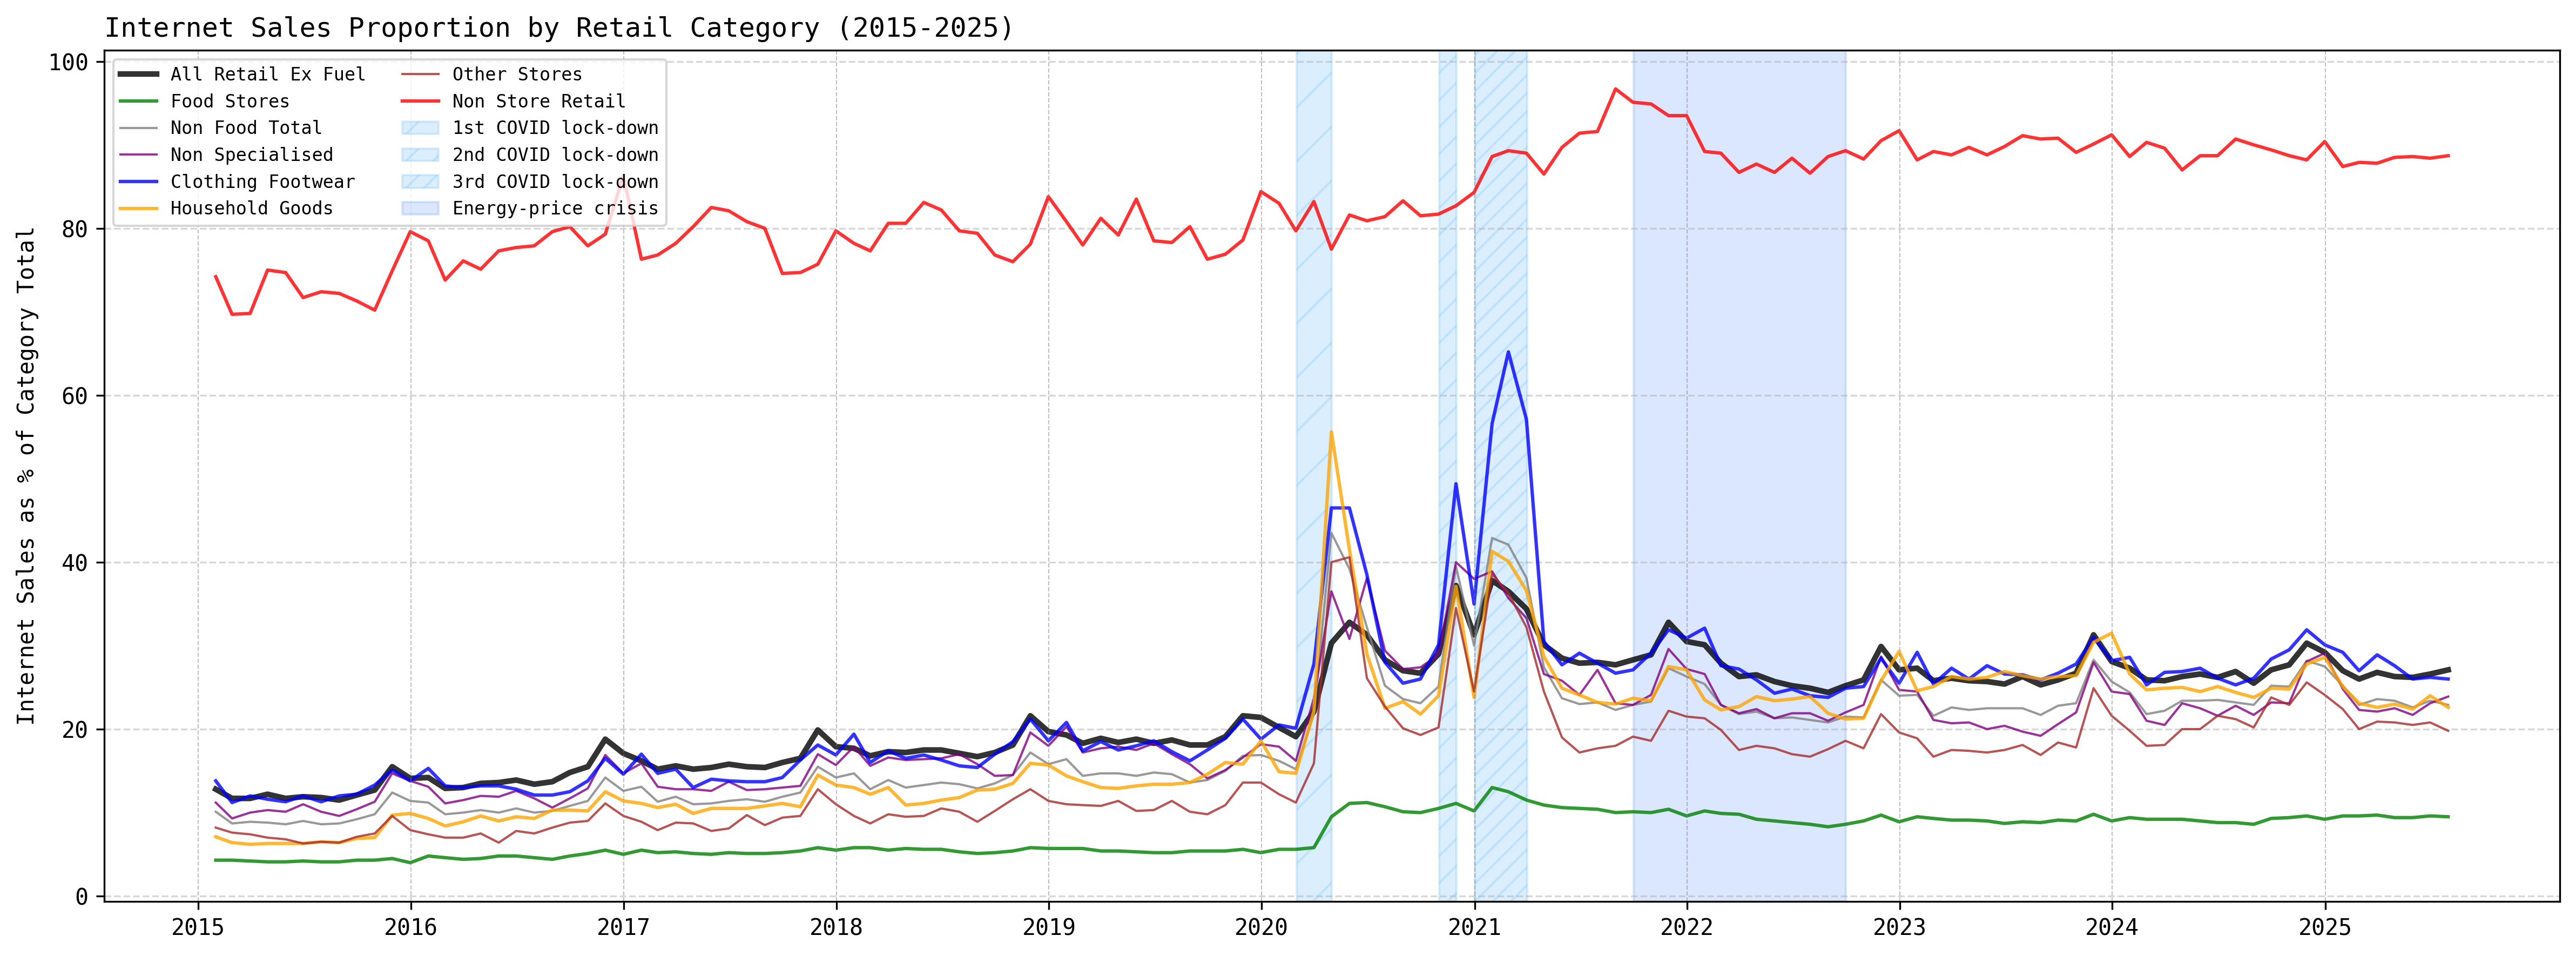

In [37]:
# Plot all categories
fig, ax = plt.subplots(figsize=(16, 6), dpi=300)

# Define colors for each category
colors = {
    'all_retail_ex_fuel': 'black',
    'food_stores': 'green',
    'clothing_footwear': 'blue',
    'household_goods': 'orange',
    'non_store_retail': 'red',
    'non_food_total': 'gray',
    'non_specialised': 'purple',
    'other_stores': 'brown'
}

linewidths = {
    'all_retail_ex_fuel': 2.5,
    'food_stores': 1.5,
    'clothing_footwear': 1.5,
    'household_goods': 1.5,
    'non_store_retail': 1.5,
    'non_food_total': 1,
    'non_specialised': 1,
    'other_stores': 1
}

for col in df_categories.columns:
    ax.plot(df_categories.index, df_categories[col],
            label=col.replace('_', ' ').title(),
            color=colors.get(col, 'gray'),
            linewidth=linewidths.get(col, 1),
            alpha=0.8)

# Add event spans
event_spans = add_event_spans(ax)

# Formatting
ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026)])
ax.set_xticklabels([str(year) for year in range(2015, 2026)])
for tick in ax.get_xticks():
    ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.legend(loc='upper left', fontsize=8, ncol=2)
ax.set_xlabel('')
ax.set_ylabel('Internet Sales as % of Category Total')
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.set_title('Internet Sales Proportion by Retail Category (2015-2025)', fontsize=12, loc='left')

plt.tight_layout()
plt.savefig('../outputs/figures/category_all_timeseries.png', bbox_inches='tight', dpi=300)
plt.show()

## 5. Small Multiples: Category-Specific Charts

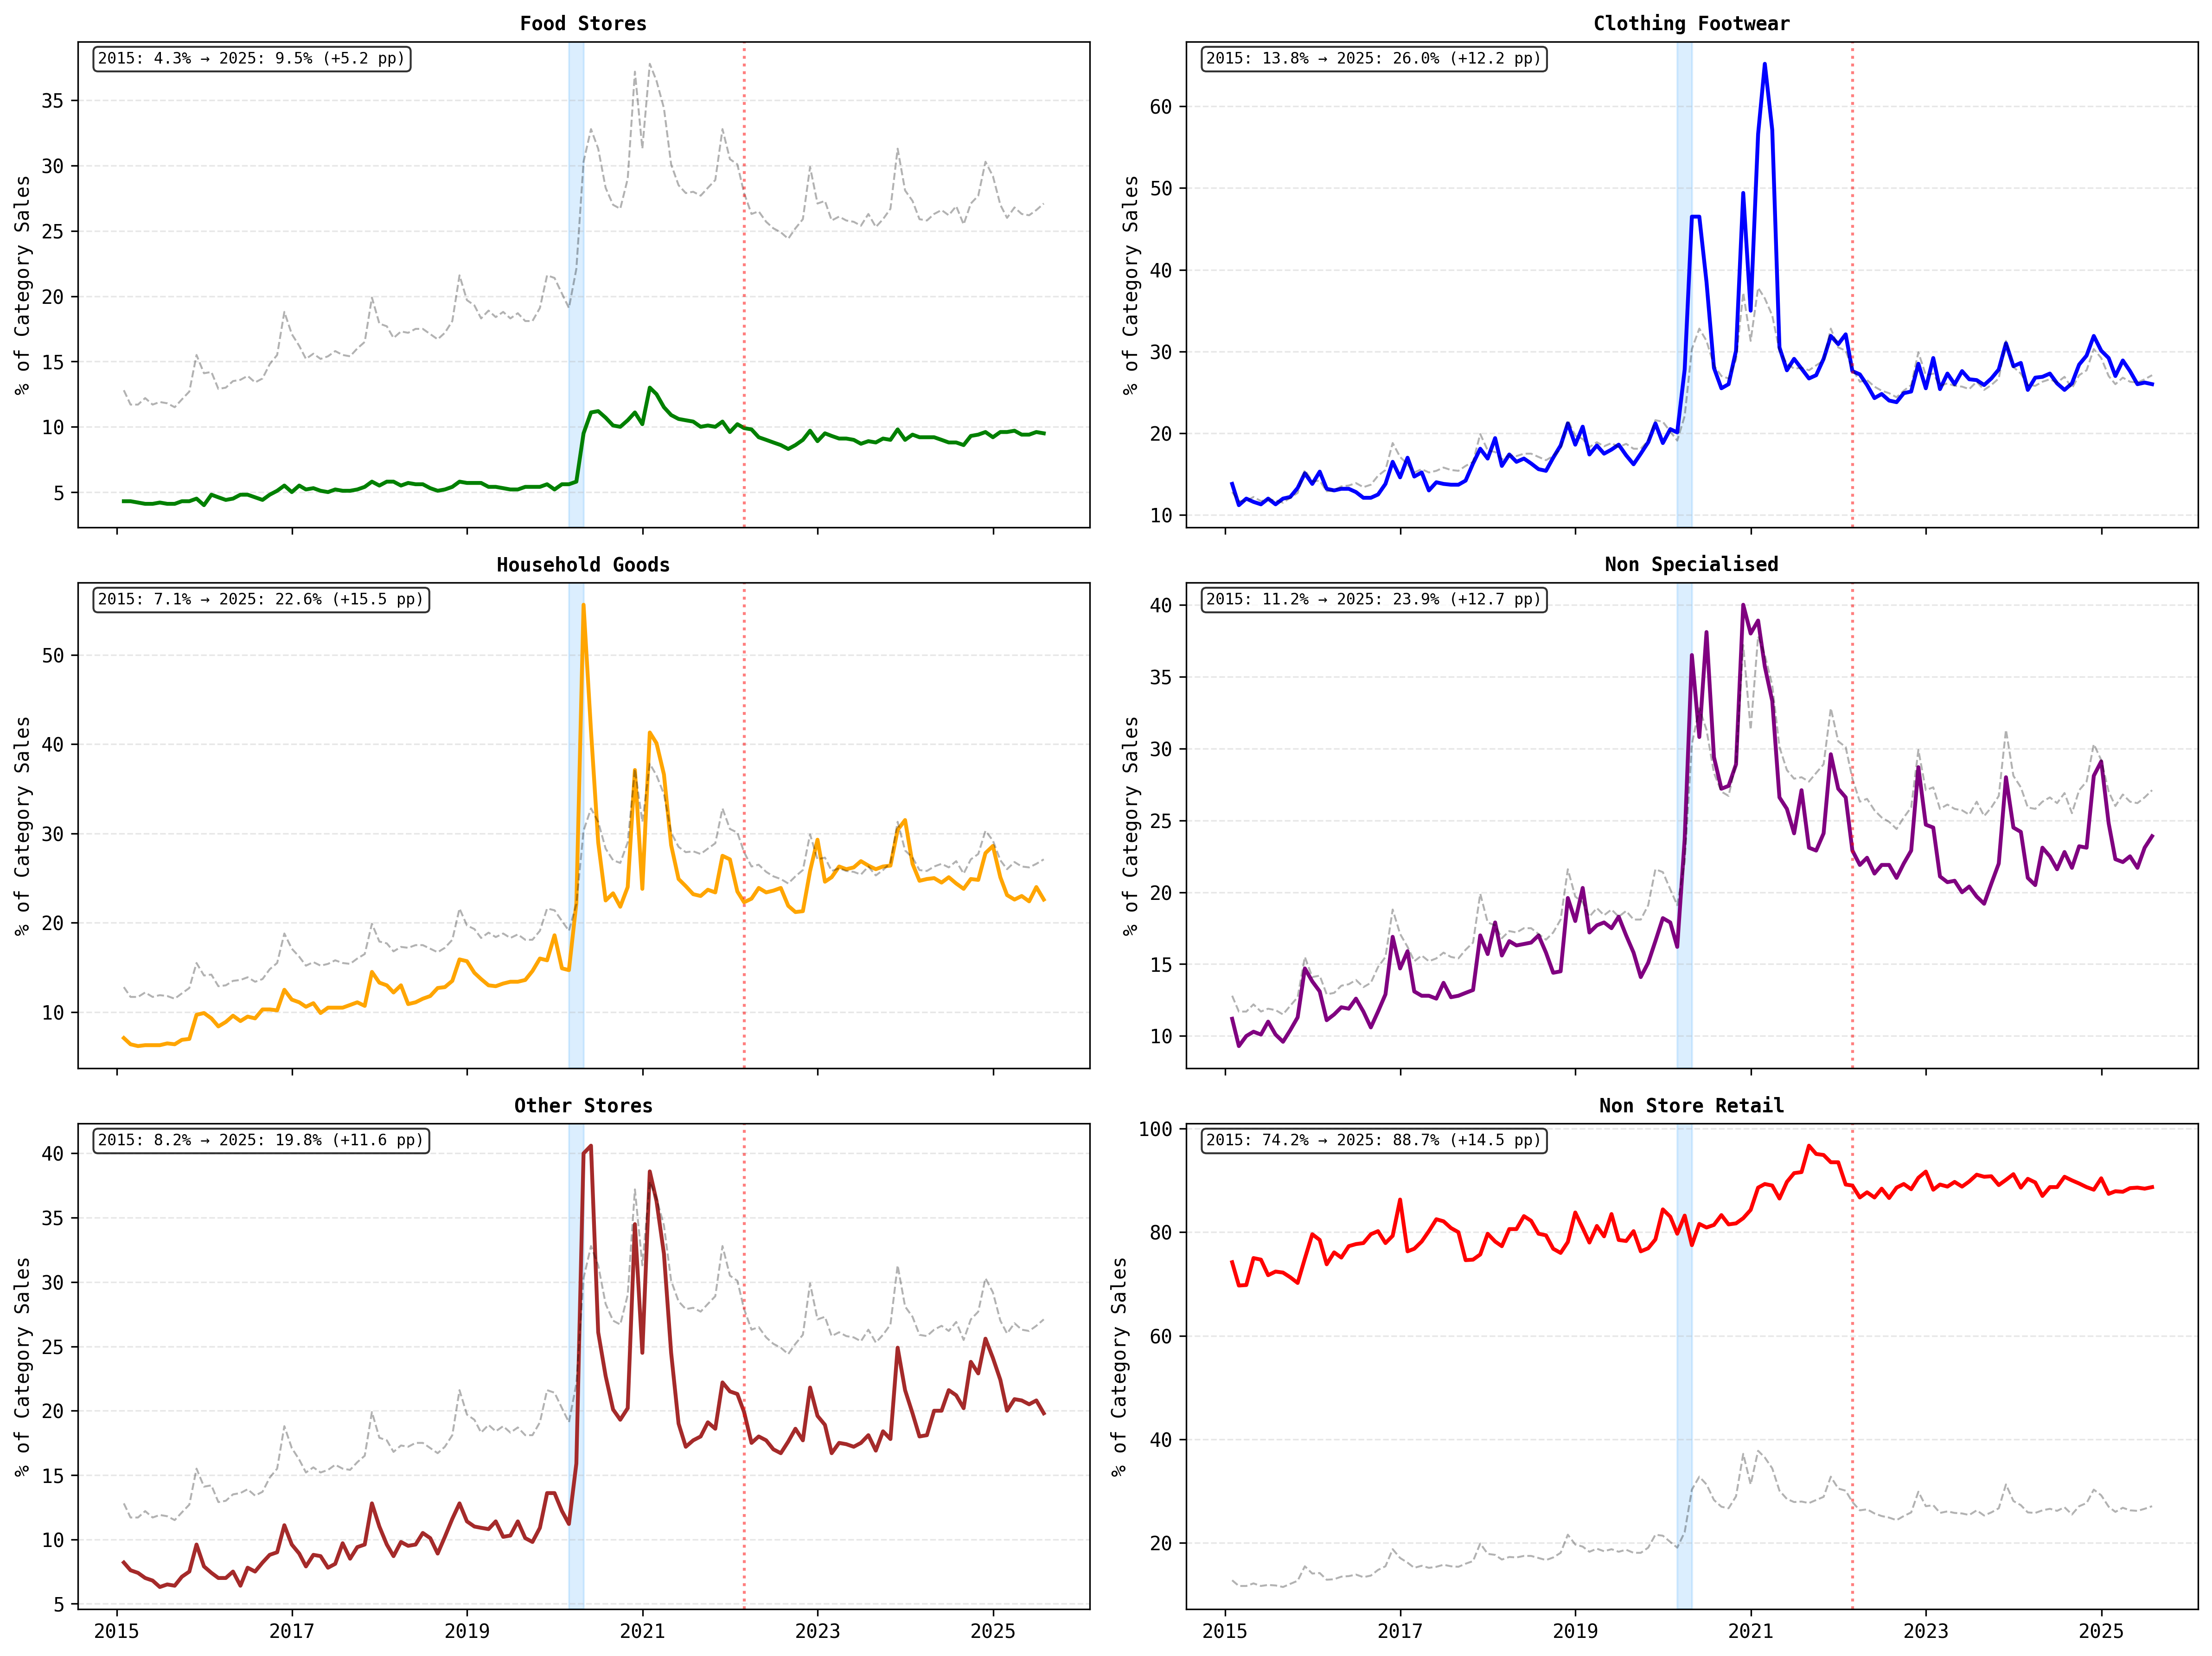

In [38]:
# Small multiples for clearer category-level view
# Exclude 'non_food_total' as it's an aggregate of subcategories
categories_to_plot = [
    'food_stores',
    'clothing_footwear',
    'household_goods',
    'non_specialised',
    'other_stores',
    'non_store_retail'
]

fig, axes = plt.subplots(3, 2, figsize=(16, 12), dpi=300, sharex=True)
axes = axes.flatten()

for idx, cat in enumerate(categories_to_plot):
    ax = axes[idx]

    # Plot category
    ax.plot(df_categories.index, df_categories[cat],
            color=colors.get(cat, 'steelblue'),
            linewidth=2)

    # Add aggregate for reference
    ax.plot(df_categories.index, df_categories['all_retail_ex_fuel'],
            color='black',
            linewidth=1,
            alpha=0.3,
            linestyle='--',
            label='All Retail (ref)')

    # Add event spans
    ax.axvspan(pd.Timestamp('2020-03'), pd.Timestamp('2020-05'),
               color="#4BADFEBF", alpha=0.2)
    ax.axvline(pd.Timestamp('2022-02-28'), color='red', linestyle=':', alpha=0.5)

    # Formatting
    ax.set_title(cat.replace('_', ' ').title(), fontsize=10, fontweight='bold')
    ax.grid(axis='y', linestyle='--', alpha=0.3)
    ax.set_ylabel('% of Category Sales')

    # Add stats text
    val_2015 = df_categories[cat].iloc[0]
    val_2025 = df_categories[cat].iloc[-1]
    change = val_2025 - val_2015
    ax.text(0.02, 0.98, f'2015: {val_2015:.1f}% → 2025: {val_2025:.1f}% ({change:+.1f} pp)',
            transform=ax.transAxes, fontsize=8, va='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Set common x-axis labels
for ax in axes[4:]:
    ax.set_xticks([pd.Timestamp(f'{year}-01-01') for year in range(2015, 2026, 2)])
    ax.set_xticklabels([str(year) for year in range(2015, 2026, 2)])

plt.tight_layout()
plt.savefig('../outputs/figures/category_small_multiples.png', bbox_inches='tight', dpi=300)
plt.show()

## 6. Save Processed Data

In [39]:
# Save category data
output_file = processed_data_dir / 'category_data.pkl'
df_categories.to_pickle(output_file)
print(f'✅ Category data saved to {output_file}')

# Also save as CSV for easy inspection
csv_file = processed_data_dir / 'category_data.csv'
df_categories.to_csv(csv_file)
print(f'✅ Category data saved to {csv_file}')

✅ Category data saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/category_data.pkl
✅ Category data saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/category_data.csv


In [40]:
# Save metadata
metadata = {
    'description': 'ONS retail category-level internet sales as proportion of total retail',
    'source': 'internetreferencetables.xlsx, sheet ISCPNSA3',
    'categories': list(df_categories.columns),
    'frequency': 'M',
    'first_obs': df_categories.index[0],
    'last_obs': df_categories.index[-1],
    'n_obs': len(df_categories),
    'category_descriptions': {
        'all_retail_ex_fuel': 'All retailing excluding automotive fuel',
        'food_stores': 'Predominantly food stores',
        'non_food_total': 'Total of predominantly non-food stores',
        'non_specialised': 'Non-specialised stores (e.g., department stores)',
        'clothing_footwear': 'Textile, clothing and footwear stores',
        'household_goods': 'Household goods stores (furniture, electronics, DIY)',
        'other_stores': 'Other stores (books, toys, sports, etc.)',
        'non_store_retail': 'Non-store retailing (mail order, markets, stalls)'
    }
}

meta_file = processed_data_dir / 'category_metadata.pkl'
with open(meta_file, 'wb') as f:
    pickle.dump(metadata, f)
print(f'✅ Metadata saved to {meta_file}')

✅ Metadata saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/category_metadata.pkl


In [41]:
# Print summary for next steps
print('\n' + '=' * 100)
print('📋 DATA PREPARATION COMPLETE')
print('=' * 100)
print(f'\nCategories available: {len(df_categories.columns)}')
print(f'Time period: {df_categories.index.min().strftime("%Y-%m")} to {df_categories.index.max().strftime("%Y-%m")}')
print(f'Total observations per category: {len(df_categories)}')
print(f'\nKey insights from initial exploration:')
print(f'  - Non-store retailing has highest online share: {df_categories["non_store_retail"].mean():.1f}% average')
print(f'  - Food stores have lowest (but growing): {df_categories["food_stores"].mean():.1f}% average')
print(f'  - Clothing shows highest COVID spike: peaked at {df_categories["clothing_footwear"].max():.1f}%')
print(f'\n✅ Ready for regime analysis in notebook 05')


📋 DATA PREPARATION COMPLETE

Categories available: 8
Time period: 2015-01 to 2025-07
Total observations per category: 127

Key insights from initial exploration:
  - Non-store retailing has highest online share: 83.3% average
  - Food stores have lowest (but growing): 7.4% average
  - Clothing shows highest COVID spike: peaked at 65.2%

✅ Ready for regime analysis in notebook 05
